# Interpretable Machine Learning
## Exercise Sheet 7: Counterfactuals and Adversarial Examples
## This exercise sheet covers lecture 7 on Counterfactuals and Adversarial Examples
Sophie Langbein (langbein@leibniz-bips.de)<br>
Pegah Golchian (golchian@leibniz-bips.de)
<hr style="border:1.5px solid gray"> </hr>

# Counterfactual Explanations

Counterfactual explanations are a valuable tool to explain predictions of machine learning models. They provide an understanding of how a machine learning model's prediction for a specific instance would change if the input features were altered in a meaningful way. These explanations are generated by identifying a "counterfactual" instance, which is a data point that is as similar as possible to the original instance but with some feature values modified. The goal is to explain to end-users how they could change their input to receive a different model prediction.

One of the simplest approaches to generate counterfactuals is to determine for a given observation x (`x_interest`) the closest data point which has a prediction equal to the desired outcome. In the following exercise, you should implement this so called **WhatIf** approach for a binary classifier. 

**a)** Implement the following steps in `generate_whatif()`:

- Create a dataset containing only the values with a prediction different to the one of `x_interest` (this is equal to our desired prediction).
- Calculate the pairwise Gower’s distances between `x_interest` and all other points with differing predictions.
- Return the nearest data point as a counterfactual for `x_interest` with the shape (1, num_features).

**Solution:**

In [2]:
import gower
import numpy as np

def generate_whatif(x_interest, model, dataset): 
  
    """
    Computes whatif counterfactuals for binary classification models, 
    i.e., the closest data point with a different prediction.
  
    Parameters: 
    x_interest (np.array with shape (1, num_features)): Datapoint of interest.
    model: Binary classifier which has a predict method.
    dataset (np.array with shape (?, num_features)): Input data from which a counterfactual is selected.

    Returns:
    counterfactual (np.array with shape (1, num_features)): the closest observation/row to x_interest of the input dataset with a different prediction than x_interest. 
    """

    # subset dataset to the observations having a prediction different to x_interest
    pred = model.predict(x_interest) # calculate the prediction for the x_interest data point using the provided model
    preddata = model.predict(dataset) # calculates predictions for all data points in the dataset using the same model
    idx = preddata != pred # creates a boolean index idx that selects rows in the dataset where the predictions are different from the prediction of x_interest
    dataset = dataset[idx,] # dataset is subset to include only the rows with different predictions, selecting data points where the counterfactuals should be found
  
    # Pairwise Gower distances 
    dists = gower.gower_matrix(data_x = dataset, data_y = x_interest) # compute the dissimilarity (distance) between each row in the subset of the dataset and the x_interest data point
    minid = dists.flatten().argsort()[0] # flatten dist matrix, the index of the smallest value is found using the argsort function
  
    # Return nearest datapoint
    return dataset[minid,:].reshape(1, -1) # closest counterfactual data point is selected from the dataset and reshaped to have the shape (1, num_features)

**b)** Write a function `evaluate_counterfactual()` to evaluate whether a counterfactual is minimal. In other words, the function should check, if setting one feature to the value of `x_interest`, still results in a different prediction than for `x_interest`. It should return a list with names of features that if set for the counterfactual to the value of `x_interest`, still lead to a different prediction than for `x_interest`. Hence the function should check for every feature, whether setting it equal to its value in `x_interest` leads to a different prediction than the prediction of `x_interest` and if so, record the corresponding feature value. 

**Solution:**

In [3]:
def evaluate_counterfactual(counterfactual, x_interest, model, labels) :
    """
    Evaluates if counterfactuals are minimal, i.e., if setting one feature to the value of x_interest still results in a different prediction than for x_interest.
   
    Parameters: 
    counterfactual (np.array with shape (1, num_features)): Counterfactual of `x_interest`. 
    x_interest (np.array with shape (1, num_features)): Datapoint of interest. 
    model: Binary classifier which has a predict method.
    labels (list): A list of the labels of the feature matrix. 
  
    Returns: 
    List with names of features that if set for the counterfactual to the value of `x_interest`, still leads to a different prediction than for x_interest. 
    """

    pred = model.predict(x_interest)[0] # extract the prediction for the x_interest data point as a scalar value
    feature_names = [] # initialize an empty list, which will be used to store the names of features that, when changed, lead to different predictions
    numfeat = counterfactual.shape[1] # calculate the number of features in the counterfactual data point.
    for i, name in zip(range(0, numfeat), labels) :  #  iterate over feature indices i and feature names name. The zip function pairs each feature index with its name
        if (counterfactual[0, i] != x_interest[0, i]) : # check if the counterfactual feature value for feature i is different from the x_interest feature value for the same feature
            newcf = counterfactual.copy() # copy of the counterfactual data point 
            newcf[0, i] = x_interest[0, i] # sets the value of the feature i in the newcf data point to be the same as the value in the x_interest data point
            newpred = model.predict(newcf)[0] # calculate the prediction for the modified newcf data point
            if (newpred != pred) : # check if the new prediction (newpred) is different from the original prediction (pred), it means that changing the feature led to a different prediction
                feature_names.append(name) # append to list if the feature change resulted in a different prediction
        else : 
            continue # if the feature values are the same for the counterfactual and x_interest, the loop continues to the next feature without making any changes
    return feature_names

**c)** Now, to test the `generate_whatif()` and `evaluate_counterfactual()` functions, import the [wheat seeds dataset](https://archive.ics.uci.edu/dataset/236/seeds) from `wheat_seeds.csv`, which was already used in Exercise Session 6. 

- Drop all rows that contain `NA` values. 
- Convert the dataset into a dataset suitable for binary classification, by dropping all observations of type `Canadian` (`Type` = `2`). We only want to classify whether a kernel is of type `Kama` (`Type` = `0`) or `Rosa` `Type` = `1`). 
- Fit a random forest classifier to the full dataset (no training and test set required)
- Choose a suitable point for `x_interest`, check whether the prediction matches the true value. 

**Solution:**

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split


# Import wheat seeds dataset
dataset = pd.read_csv("wheat_seeds.csv")

# Drop rows with NaN values
dataset = dataset.dropna()

# Create a binary classification task
dataset = dataset[dataset["Type"]!=2]

# Specify the feature columns (X) and the target column (y)
X = dataset.drop("Type", axis=1)  # X contains all columns except the "Type" column
y = dataset["Type"]  # y contains the "Type" column

In [5]:
from sklearn.ensemble import RandomForestClassifier
      
# Fit a random forest to the data
model = RandomForestClassifier(random_state=0)
model.fit(np.array(X), np.array(y))
  
# Define x_interest and make a prediction
x_interest = np.array(X.iloc[0]).reshape(1, -1)
model.predict(x_interest)
print("The true value is: " + str(y[0]) + " The predicted value is: " + str(model.predict(x_interest)[0]))

The true value is: 1.0 The predicted value is: 1.0


In [6]:
# Check the shape of the array
x_interest.shape

(1, 7)

**d)** Compute the WhatIf counterfactual of the selected observation and interpret it. Evaluate whether it is minimal.

**Solution:**

In [7]:
# Compute counterfactual for first observation
cf = generate_whatif(x_interest = x_interest, model = model, dataset = np.array(X))
cf

array([[13.37  , 13.78  ,  0.8849,  5.32  ,  3.128 ,  4.67  ,  5.091 ]])

In [8]:
# for comparison 
x_interest

array([[15.26 , 14.84 ,  0.871,  5.763,  3.312,  2.221,  5.22 ]])

In [9]:
X.columns

Index(['Area', 'Perimeter', 'Compactness', 'Kernel.Length', 'Kernel.Width',
       'Asymmetry.Coeff', 'Kernel.Groove'],
      dtype='object')

In [10]:
print("The prediction for the Kernel changes from kernel type 'Rosa' (=1) to kernel type 'Kama' (=0), if the Area is decreased by " + 
      str(round(x_interest[0,0]-cf[0,0],3)) + 
      ", the Perimeter is decreased by " 
      + str(round(x_interest[0,1]-cf[0,1],3)) + 
      ", the Compactness is increased by " + 
      str(round(cf[0,2]-x_interest[0,2],3)) + 
      ", the Kernel length is decreased by " + 
      str(round(x_interest[0,3]-cf[0,3],3)) + 
      ", the Kernel width is decreased by " + 
      str(round(x_interest[0,4]-cf[0,4],3)) + 
      ", the Asymmetry Coefficient is increased by " + 
      str(round(cf[0,5]-x_interest[0,5],3)) + 
      ", the Kernel Groove is decreased by " + 
      str(round(x_interest[0,6]-cf[0,6],3)) + ".") 

The prediction for the Kernel changes from kernel type 'Rosa' (=1) to kernel type 'Kama' (=0), if the Area is decreased by 1.89, the Perimeter is decreased by 1.06, the Compactness is increased by 0.014, the Kernel length is decreased by 0.443, the Kernel width is decreased by 0.184, the Asymmetry Coefficient is increased by 2.449, the Kernel Groove is decreased by 0.129.


In [11]:
round(x_interest[0,1]-cf[0,1],3)

1.06

In [12]:
# Evaluate whether counterfactual is minimal
evaluate_counterfactual(counterfactual = cf, x_interest = x_interest, model = model, labels = X.columns)

['Compactness', 'Kernel.Length', 'Kernel.Width', 'Kernel.Groove']

We observe that there are four features, that if set equal to their values in `x_interest` still lead to a different prediction. Therefore, the counterfactual is not minimal, which makes it not very valuable, from an intuitive point of view. 

**e)** Which attributes from the lecture (valid, proximal/similar, sparse, plausible/likely, diverse) does this approach fulfill? Based on this, derive the advantages and disadvantages of the approach.

**Solution:**

Counterfactuals generated with WhatIf are valid and proximal, since they reflect the closest training datapoint with the desired/different prediction. The counterfactuals are also plausible since by definition they adhere to the data manifold. However, clearly the counterfactuals are not sparse, since every feature is changed in the counterfactual example above. This is a clear disadvantage of this method, making the resulting counterfactual less intuitive to interpret. 

**f)** Now we want to use the [DiCE](https://github.com/interpretml/DiCE) (Diverse Counterfactual Explanations) package to generate counterfactual explanations for the same data. For that purpose at first:

- Split the data into training and test set. 
- Fit a random forest classifier to the training data.
- Compute the accuracy on the test set.

**Solution:**

In [13]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Split data into training and test set
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=0)

In [14]:
# Fit a random forest classifier
model = RandomForestClassifier(random_state=0)  
model.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

In [15]:
from sklearn.metrics import accuracy_score

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", round(accuracy,3))

Accuracy: 0.923


**g)** Now we generate the counterfactuals using the `DiCE` package. For that purpose: 
    
- Transform the data into an appropriate format using `dice_ml.Data`.
- Select two instances of interest from the test set for which counterfactuals should be generated (ideally they should have different outcomes).
- Generate counterfactuals using the `exp_random.generate_counterfactuals`function. For every instance of interest three counterfactuals should be generated. Only the features `Area` and `Perimeter` should be varied, while all other features should remain constant. 
- Visualize the counterfactuals as dataframes. 

Hint: In this [notebook](https://github.com/interpretml/DiCE/blob/main/docs/source/notebooks/DiCE_model_agnostic_CFs.ipynb) you can find a tutorial on how to generate DiCE counterfactuals using three different algorithms, you can chose the algorithm you prefer, random feature sampling is recommended. 

**Solution:**

In [16]:
import dice_ml
from raiutils.exceptions import UserConfigValidationException

# Transform the data
training_set = X_train.copy()
training_set.insert(0, 'Type', y_train)
d = dice_ml.Data(dataframe=training_set, continuous_features=list(X_train.columns), outcome_name='Type')

# Select instances of interest 
instances = X_test[4:6]

In [17]:
# Provide the trained model to DiCE's model object
backend = 'sklearn'
dice_model = dice_ml.Model(model=model, backend=backend)

# Initiate DiCE
exp_random = dice_ml.Dice(d, dice_model, method="random")

# Generate counterfactuals
dice_exp_random = exp_random.generate_counterfactuals(instances, 
                                                      total_CFs=3, 
                                                      desired_class="opposite",
                                                      features_to_vary=['Area', 'Perimeter'],
                                                      verbose = False, 
                                                      random_seed=9)

100%|██████████| 2/2 [00:00<00:00, 10.78it/s]


In [18]:
# Visualize counterfactuals in dataframe
dice_exp_random.visualize_as_dataframe(show_only_changes=True)

Query instance (original outcome : 0)


,Area,Perimeter,Compactness,Kernel.Length,Kernel.Width,Asymmetry.Coeff,Kernel.Groove,Type
0,10.83,12.96,0.8099,5.278,2.641,5.182,5.185,0



Diverse Counterfactual set (new outcome: 1.0)


,Area,Perimeter,Compactness,Kernel.Length,Kernel.Width,Asymmetry.Coeff,Kernel.Groove,Type
0,16.59,15.16,0.8099,5.278,2.641,5.182,5.185,1.0
1,14.06,14.0,0.8099,5.278,2.641,5.182,5.185,1.0
2,16.15,14.96,0.8099,5.278,2.641,5.182,5.185,1.0


Query instance (original outcome : 1)


,Area,Perimeter,Compactness,Kernel.Length,Kernel.Width,Asymmetry.Coeff,Kernel.Groove,Type
0,15.49,14.94,0.8724,5.757,3.371,3.412,5.228,1



Diverse Counterfactual set (new outcome: 0.0)


,Area,Perimeter,Compactness,Kernel.Length,Kernel.Width,Asymmetry.Coeff,Kernel.Groove,Type
0,11.64,12.89,0.8724,5.757000000000001,3.3710000000000004,3.412,5.228,0.0
1,11.7,12.92,0.8724,5.757000000000001,3.3710000000000004,3.412,5.228,0.0
2,12.07,13.09,0.8724,5.757000000000001,3.3710000000000004,3.412,5.228,0.0


**h)** Which attributes from the lecture (valid, proximal/similar, sparse, plausible/likely, diverse) do the counterfactuals generated above fulfill?

**Solution:**

The above counterfactuals generated with DiCE are valid, proximal, sparse and diverse. The core idea of DiCE counterfactuals is to setup finding such counterfactuals as an optimization problem. The aim is to identify perturbations that change the output of a machine learning model, but are also diverse and feasible to change. Therefore, DiCE supports generating a set of counterfactual explanations and has tunable parameters for diversity and proximity of the explanations to the original input. It also supports simple constraints on features to ensure feasibility of the generated counterfactual examples. DiCE generates counterfactuals that are as close as possible to the original instance, ensuring that the changes made to the feature values are small while still resulting in a different model prediction. DiCE allows us to produce sparse counterfactual explanations by choosing specific features to be modified for the counterfactuals, which can be helpful in real-world application contexts. Naturally, without specifying specific features DiCE also attempts to modify as few features as possible to achieve a different model prediction.

However, the generated counterfactuals are not necessarily plausible, since they do not need to adhere to the data manifold. DiCE can be configured to take into account domain-specific constraints and feasibility requirements when generating counterfactuals, e.g. by specifying the range within certain features are allowed to vary. 

For further information check the paper by Mothilal et al. (2019) https://arxiv.org/abs/1905.07697. 

<hr style="border:1.5px solid gray"> </hr>

# Adversarial Examples

Adversarial examples are inputs to machine learning models that are intentionally crafted to cause the model to make mistakes. These inputs are carefully designed to be very similar to genuine data instances but are subtly perturbed in ways that are imperceptible to humans. Adversarial examples have gained significant attention in the field of artificial intelligence and machine learning because they highlight vulnerabilities in the robustness of machine learning models.

Adversarial Examples are carefully constructed inputs that “fool” a trained model. In this exercise, your task is to generate adversarial examples using the Fast-Gradient-Sign-Method:

$$
\mathbf{a}_\mathbf{x} ← \mathbf{x} + \delta 
$$

where 

$$
\delta = \epsilon \cdot \text{sign}(\nabla_{\mathbf{x}}J(\mathbf{x}, y_{\mathbf{x}}; \theta)) 
$$

with a cost function J (here, we will use cross entropy loss). This is an untargeted method, which means the resulting class label is not specified in advance. The goal is to create an adversarial input that is indistinguishable (to the human eye) from an original input, but confuses the model. In particular, we will create adversarial examples to fool an image classifier trained on the ImageNet dataset.

**a)** First import all relevant modules including the custom functions from the `utils.dataset` module. Complete the `get_gradient()` function. The function should take the original `image` and the fitted `model` as an input and return the gradient of the loss with respect to the image. It should perform the following steps:

- Obtain a prediction for the input `image` tensor
- Set the `requires_grad` attribute of the `image` tensor to `True`
- Pass the image tensor through the model to obtain its output
- Compute the cross-entropy loss between the model outputs of the image tensor and the prediction obtained for the input image using the `torch.nn.functional.cross_entropy` function
- Perform backpropagation to compute the gradients of the loss with respect to the input image tensor
- Return the gradient of the loss with respect to the image

**Solution:**

In [19]:
# All relevant imports
import sys
import os  # noqa
sys.path.insert(0, "")  # noqa

import torch

# These are custom modules included in the exercises session
from utils.styled_plot import plt
from utils.dataset import (
    load_test_image,
    preprocess_image,
    normalize_image,
    unnormalize_image,
    convert_idx_to_label
)
from classifiers.cnn_classifier import ImageNetClassifier

torch.manual_seed(0)

In [20]:
def get_gradient(model, image):
    """
    Propagates the cross entropy loss between the model's output (logits) and the label (here the label
    that is predicted by the model is used) back to the input to get the input gradient.

    Parameters:
        model (ImageNetClassifier, torch.nn.Module):
            The image classification model. This is a torch.nn.Module, so you can call its forward method using
            `model()`. The output are logits (class probabilities). Also has a `.predict` method that returns the
            index of the predicted label.

        image (torch.tensor): The input for which to compute the gradient.

    Returns:
        gradient (torch.tensor): The input gradient. Same shape as the input image.
    """

    prediction = model.predict(image) # obtain a prediction for the given image
    image.requires_grad = True # set the requires_grad attribute of the image tensor to True. This is a PyTorch feature that allows you to compute gradients with respect to this tensor during backpropagation
    outputs = model(image) # pass the image tensor through the model to obtain its output
    loss = torch.nn.functional.cross_entropy(outputs, prediction) # compute the cross-entropy loss between the outputs (logits) and the prediction
    loss.backward() # perform backpropagation to compute the gradients of the loss with respect to the input image
    return image.grad # return the gradient of the loss with respect to the image

**b)** Complete the `perturb_image()` function. It should perform the following steps: 

- Calculate the sign of each element in the input `grad` tensor as the perturbation
- Scale the sign of the gradient using `eps`
- Add the scaled pertubation to the original input `image` to create the perturbed image
- Return the perturbed image

**Solution:**

In [21]:
def perturb_image(image, grad, eps):
    """
    Applies a perturbation to an image based on the Fast-Gradient-Sign-Method.

    Parameters:
        image (torch.tensor): The image to perturb.

        grad (torch.tensor): The input gradient corresponding to the image.

        eps (float): The epsilon value for the perturbation, specifying the magnitude of the perturbation.

    Returns:
        image (torch.tensor): The perturbed image.
    """

    g = grad.sign() # calculate the sign of each element in the grad tensor as the perturbation
    p = eps * g # scale the sign of the gradient by the value of eps, effectively determining the direction and magnitude of the perturbation
    perturbed_image = image + p # add the scaled perturbation to the original image, creating the perturbed image
    return perturbed_image

**c)** Complete the `create_adversarials()` function. It should perform the following steps: 

- Calculate the gradient of the model's output with respect to the input image using the `get_gradient()` function.
- Create a list of adversarial examples by perturbing the input image for each epsilon value in `eps_values` using the `perturb_image()` function.
- Return the list of adversarial examples. 

**Solution:**

In [22]:
def create_adversarials(model, image, eps_values):
    """
    Creates adversarial examples for the given image and model using the Fast-Gradient-Sign-Method.

    Parameters:
        model (ImageNetClassifier, torch.nn.Module):
            The image classification model. This is a torch.nn.Module, so you can call its forward method using `model()`.
            Also has a `.predict` method that returns the index of the predicted label.

        image (torch.tensor): The image to generate adversarial examples from.

        eps_values (List[float]): The list of epsilon values for which to generate adversarial examples.

    Returns:
        adversarials (List[torch.tensor]): A list containing one adversarial example for each eps value in eps_values.
    """

    grad = get_gradient(model, image) # calculate the gradient of the model's output with respect to the input image
    adversarials = [perturb_image(image, grad, eps) for eps in eps_values] # create a list of adversarial examples by perturbing the input image for each epsilon value in eps_values
    return adversarials # return a list of adversarial examples

**d)** Familiarize yourself with the `plot_adversarials()` function, which is used to plot the original image and the adversarial images in a single row. 

**Solution:**

In [23]:
def plot_adversarials(model, image, adv_images, eps_values):
    """
    Plots the  original image and the adversarial images in a single row.
    Uses the eps value and the predicted label as axis titles.

    Parameters:
        model (ImageNetClassifier, torch.nn.Module):
            The image classification model. This is a torch.nn.Module, so you can call its forward method using `model()`.
            Also has a `.predict` method that returns the index of the predicted label.

        image (torch.tensor): The original image corresponding to the adversarial examples.

        adv_images (List[torch.tensor]): A list containing the adversarial examples to visualize.

        eps_values (List[float]): The list of epsilon values corresponding to each adversarial example in adv_images.

    Hint: 
        - matplotlib expects a channels last format
        - The model works with normalized images. Before visualizing the images, you have to invert the normalization
        using `unnormalize()`
    """

    fig, axes = plt.subplots(len(adv_images) + 1, 1) # create a subplot for plotting the images. It creates a figure (fig) and a list of axes (axes). The number of axes is set to be len(adv_images) + 1, which allows space for the original image and all the adversarial images
    predictions = model.predict(torch.cat([image] + adv_images)) # make predictions for the original image and all the adversarial images combined by concatenating image and adv_images into a single tensor

    axes[0].imshow(unnormalize_image(image).squeeze().permute(1,2,0).detach().numpy()) # display the original image on the first axis axes[0], unnormalize_image(image): unnormalizes the image, squeeze(): removes any singleton dimensions from the tensor, permute(1,2,0): change the tensor's dimension order to match the expected channels-last format, detach().numpy(): converts the tensor to a NumPy array for visualization
    axes[0].axis('off') # turn off the axis (axis labels) for the original image.
    axes[0].set_title(f'eps: {0.0}\npred: {convert_idx_to_label(predictions[0].item())}') # sets the title for the original image
    plt.tight_layout() # adjust the subplot layout for better spacing
    for i, ax in enumerate(axes[1:]): # for loop that iterates through a sequence of axes, skipping the first one
        ax.imshow(unnormalize_image(adv_images[i]).squeeze().permute(1,2,0).detach().numpy()) # set up the current axis (ax) to display an image similar to aboveeffectively reducing dimensionality if there are dimensions with size 1
        ax.axis('off') # turn off the axis (axis labels) for the current axis (ax)
        ax.set_title(f'eps: {eps_values[i]}\npred: {convert_idx_to_label(predictions[i+1].item())}') # set title for the current axis
        plt.tight_layout() # adjust the layout of the subplots

**e)** Now we load and preprocess a test image, for which adversarial examples should be created as described down below. The custom `ImageNetClassifier()` from the custom `cnn_classifier` module is initialized as the prediction model. Perform the following steps: 

- Make a prediction for the preprocessed and normalized test input image using the `model.predict()` method. Set `return_probs=True` and return both the  predicted class (`y_pred`) and the predicted class probability (`y_prob`)
- Print the predicted class label by passing `y_pred.item()` to the `convert_idx_to_label()` function
- Print the predicted class probability `y_prob.item()`
- Check if the predicted class index (`y_pred`) matches the expected class index of 13 (`torch.tensor([13])`), the true label of the input image

**Solution:**

In [24]:
# Loading and preprocessing of the test image using the costum modules
image = load_test_image()
image_preprocessed = preprocess_image(image)
image_preprocessed_norm = normalize_image(image_preprocessed).unsqueeze(0)

# Initialize the model
model = ImageNetClassifier()

In [25]:
# Make prediction for normalized input image and check whether prediction is correct
y_pred, y_prob = model.predict(image_preprocessed_norm, return_probs=True) # make a prediction using the model on the input image data
print(f'Predicted class: "{convert_idx_to_label(y_pred.item())}". Confidence: {y_prob.item() * 100:.2f}%') # print out the predicted class and the confidence (probability) of the prediction
assert y_pred == torch.tensor([13]) # perform an assertion to check if the predicted class index (y_pred) matches the expected class index of 13

Predicted class: "junco, snowbird". Confidence: 94.83%


**f)** Generate five adversarial images using the `create_adversarial_function()`on the preprocessed and normalized image and the `ImageNetClassifier()` as the input model. Then plot the adversarial examples using the `plot_adversarials()` function. 

**Solution:**

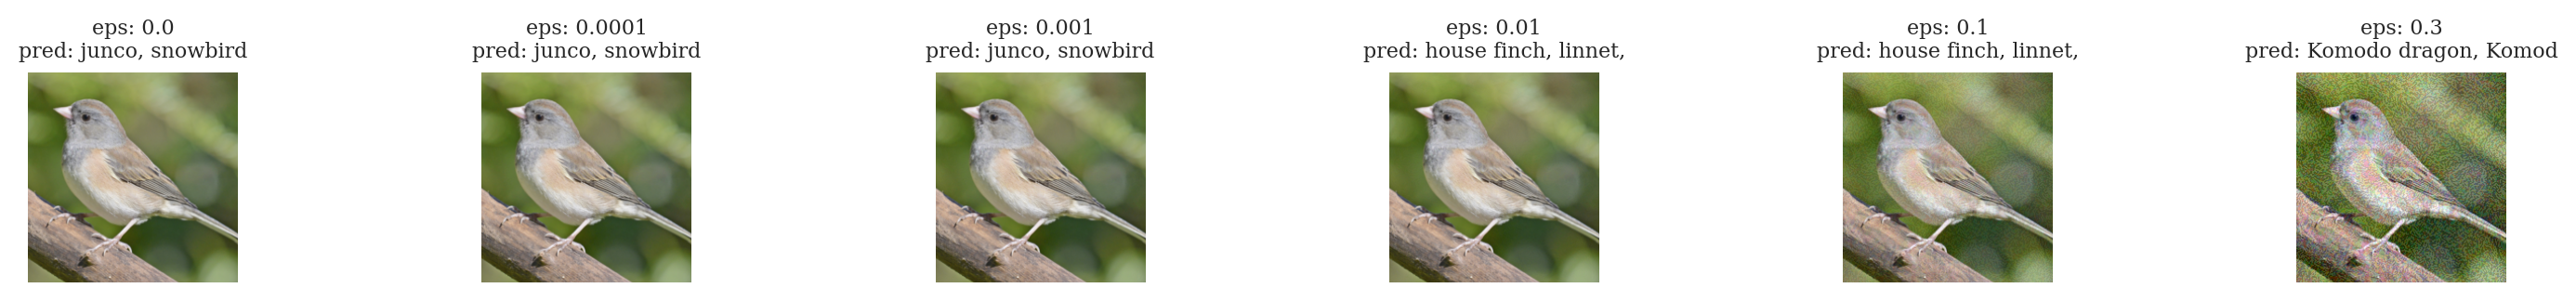

In [26]:
# Create adversarials
eps_values = [0.0001, 0.001, 0.01, 0.1, 0.3]
adv_images = create_adversarials(model, image_preprocessed_norm, eps_values)

# Plot adversarials
plot_adversarials(model, image_preprocessed_norm, adv_images, eps_values)
plt.show()

**g)** What is the difference between counterfactuals and adversarial examples? 

**Solution:**

In a nutshell, mathematically speaking, counterfactuals and adversarial examples are the same, as they can be obtained by solving the same optimization problem, such as proposed by Wachter et al. (2017) or Szegedy et al. (2014). Their difference lies solely in their purpose. Adversarial examples show where an ML model fails, and examining these failures deepens our understanding of the model (Tomsett et al., 2018; Dong et al., 2017). Counterfactuals on the other serve as explanation methods/interpretable machine learning techniques, which aim to show how ML algorithms can be improved to make them more robust against AEs (Molnar, 2019). 

In reality of course, the relationship is a bit more nuanced. For a more detailed discussion you can refer to Freisleben (2020) https://arxiv.org/abs/2009.05487. 

<hr style="border:1.5px solid gray"> </hr>